# Práctica 3b. Procesamiento de imágenes

1. El negativo de una imagen es el resultado de aplicar lasiguiente operación: 255-imagen(i,j). Aplica esta operación sobre la imagen2.png y, posteriormente, crea un video que vaya mezclando las dos imágenes por columnas, de forma que aparezca primero el negativo de la imagen y vaya apareciendo poco a poco la imagen original. El número de iteraciones debe ser igual al ancho de la imagen y en cada una se debe ir desplazando una columna a la derecha la imagen original sobre el negativo. Guarda el vídeo con el nombre vídeo2.mp4. (1.0 puntos)

In [29]:
import cv2 as cv
import numpy as np

img = cv.imread("recursos/imagen2.png")
alto, ancho, canales = img.shape

img_invertida = 255-img

nombre_video = 'video2.mp4'
fourcc = cv.VideoWriter_fourcc(*'mp4v')
video = cv.VideoWriter(nombre_video, fourcc, 30, (ancho, alto))

frame = img_invertida
frame_original = img

for i in range(0, ancho):
    frame[:, :i] = frame_original[:, :i]
    video.write(frame)

video.release()

print(f"Vídeo guardado como {nombre_video}")

Vídeo guardado como video2.mp4


2. Desarrolla una pequeña aplicación que mediante trackbars permita hacer transformaciones en el rango dinámico(logarítmica y exponencial) seleccionando la intensidad de la compresión/expansión. Selecciona dos imágenes donde el efecto de ambas transformaciones se perciba claramente. (1.0 puntos)

In [28]:
import cv2
import numpy as np

# ===========================================
# CARGAR IMAGEN EN ESCALA DE GRISES
# ===========================================
image_path = "images/ej3_oscura.jpg"
img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
if img is None:
    raise ValueError("No se pudo cargar la imagen.")

cv2.imshow("Original", img)
cv2.waitKey(1)

L = 256  # número de niveles de intensidad posibles (255 niveles en imágenes de 8 bits)

# ===========================================
# COMPRESIÓN LOGARÍTMICA
# s = c * log(1 + sigma * r)
# donde c = (L-1) / log(1 + sigma * rmax)
# sigma controla la intensidad de la compresión
# ===========================================
def log_transform(img, sigma):
    """
    Transformación logarítmica para comprimir el rango dinámico.
    
    Args:
        img: imagen de entrada
        sigma: controla la intensidad de la compresión
    """
    # r es el valor original de intensidad del píxel (normalizado a [0,1])
    r = img.astype(np.float32) / 255.0
    
    # rmax: valor máximo de intensidad
    rmax = r.max()
    
    # c es una constante de escala
    c = (L - 1) / np.log(1 + sigma * rmax)
    
    # s es la nueva intensidad
    s = c * np.log(1 + sigma * r)
    
    return np.clip(s, 0, 255).astype(np.uint8)

# ===========================================
# EXPANSIÓN EXPONENCIAL
# s = c * (exp(alfa * r) - 1)
# donde c = (L-1) / (exp(alfa * rmax) - 1)
# alfa controla la intensidad de la expansión
# ===========================================
def exp_transform(img, alfa):
    """
    Transformación exponencial para expandir el rango dinámico.
    
    Args:
        img: imagen de entrada
        alfa: controla la intensidad de la expansión
    """
    # r es el valor original de intensidad del píxel (normalizado a [0,1])
    r = img.astype(np.float32) / 255.0
    
    # rmax: valor máximo de intensidad
    rmax = r.max()
    
    # c es una constante de escala
    denominator = np.exp(alfa * rmax) - 1
    if denominator == 0:
        denominator = 1e-10
    c = (L - 1) / denominator
    
    # s es la nueva intensidad
    s = c * (np.exp(alfa * r) - 1)
    
    return np.clip(s, 0, 255).astype(np.uint8)

# ===========================================
# FUNCIÓN DE ACTUALIZACIÓN
# ===========================================
def update(_=None):
    modo = cv2.getTrackbarPos("Modo (0=Log / 1=Exp)", "Transformaciones")
    param_value = cv2.getTrackbarPos("Intensidad", "Transformaciones")
    
    if modo == 0:  # Logarítmica
        # sigma: 0.1 - 20.0
        sigma = param_value / 5.0
        if sigma < 0.1:
            sigma = 0.1
        
        out = log_transform(img, sigma)
        txt1 = f"LOGARITMICA - sigma = {sigma:.2f}"
        txt2 = "s = c * log(1 + sigma * r)"
        txt3 = f"c = (L-1) / log(1 + sigma * rmax)"
        txt4 = "Compresion: expande oscuros, comprime brillos"
        
    else:  # Exponencial
        # alfa: 0.1 - 10.0
        alfa = param_value / 10.0
        if alfa < 0.1:
            alfa = 0.1
        
        out = exp_transform(img, alfa)
        txt1 = f"EXPONENCIAL - alfa = {alfa:.2f}"
        txt2 = "s = c * (exp(alfa * r) - 1)"
        txt3 = f"c = (L-1) / (exp(alfa * rmax) - 1)"
        txt4 = "Expansion: comprime oscuros, expande brillos"
    
    # Crear display con texto
    display = cv2.cvtColor(out, cv2.COLOR_GRAY2BGR)
    cv2.putText(display, txt1, (10, 25), cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0, 255, 0), 2)
    cv2.putText(display, txt2, (10, 50), cv2.FONT_HERSHEY_SIMPLEX, 0.45, (255, 255, 255), 1)
    cv2.putText(display, txt3, (10, 70), cv2.FONT_HERSHEY_SIMPLEX, 0.4, (200, 200, 200), 1)
    cv2.putText(display, txt4, (10, 90), cv2.FONT_HERSHEY_SIMPLEX, 0.45, (255, 255, 0), 1)
    
    cv2.imshow("Transformaciones", display)

# ===========================================
# CREAR INTERFAZ
# ===========================================
cv2.namedWindow("Transformaciones")
cv2.createTrackbar("Modo (0=Log / 1=Exp)", "Transformaciones", 0, 1, update)
cv2.createTrackbar("Intensidad", "Transformaciones", 25, 100, update)

# Añadir texto de ayuda en la ventana original
help_img = cv2.cvtColor(img.copy(), cv2.COLOR_GRAY2BGR)
cv2.putText(help_img, "Imagen Original", (10, 30), 
            cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 255, 255), 2)
cv2.putText(help_img, "Modo 0: Logaritmica (compresion)", (10, 60), 
            cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 1)
cv2.putText(help_img, "Modo 1: Exponencial (expansion)", (10, 85), 
            cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 1)
cv2.putText(help_img, "Presiona 'q' o ESC para salir", (10, 115), 
            cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 255, 255), 1)
cv2.imshow("Original", help_img)

update()

# ===========================================
# LOOP PRINCIPAL
# ===========================================
print("\n" + "="*60)
print("TRANSFORMACIONES DE RANGO DINAMICO")
print("="*60)
print("\nFórmulas utilizadas:")
print("\n1. LOGARITMICA (Compresión):")
print("   s = c * log(1 + sigma * r)")
print("   c = (L-1) / log(1 + sigma * rmax)")
print("   - sigma controla la intensidad de la compresión")
print("\n2. EXPONENCIAL (Expansión):")
print("   s = c * (exp(alfa * r) - 1)")
print("   c = (L-1) / (exp(alfa * rmax) - 1)")
print("   - alfa controla la intensidad de la expansión")
print("\nDonde:")
print("   r = valor original de intensidad del píxel")
print("   s = nueva intensidad")
print("   c = constante de escala")
print("   L = 256 (niveles de intensidad)")
print("   rmax = valor máximo de intensidad")
print("\nControles:")
print("   - Cambia 'Modo' para alternar entre transformaciones")
print("   - Ajusta 'Intensidad' para controlar sigma/alfa")
print("   - Presiona 'q' o ESC para salir")
print("="*60 + "\n")

while True:
    key = cv2.waitKey(1) & 0xFF
    if key in [ord("q"), 27]:
        break

cv2.destroyAllWindows()
cv2.waitKey(1)


TRANSFORMACIONES DE RANGO DINAMICO

Fórmulas utilizadas:

1. LOGARITMICA (Compresión):
   s = c * log(1 + sigma * r)
   c = (L-1) / log(1 + sigma * rmax)
   - sigma controla la intensidad de la compresión

2. EXPONENCIAL (Expansión):
   s = c * (exp(alfa * r) - 1)
   c = (L-1) / (exp(alfa * rmax) - 1)
   - alfa controla la intensidad de la expansión

Donde:
   r = valor original de intensidad del píxel
   s = nueva intensidad
   c = constante de escala
   L = 256 (niveles de intensidad)
   rmax = valor máximo de intensidad

Controles:
   - Cambia 'Modo' para alternar entre transformaciones
   - Ajusta 'Intensidad' para controlar sigma/alfa
   - Presiona 'q' o ESC para salir



-1

3. Mezcla las imágenes imagen7_1.jpg e imagen7_2.png de forma no lineal utilizando la siguiente expresión:

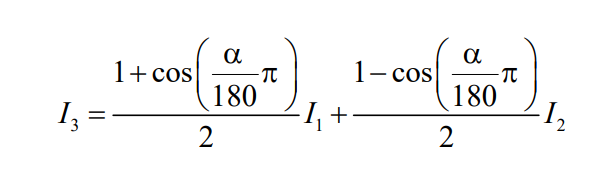

Crea un vídeo de 360 frames aumentando el ángulo en 1°
en cada iteración y guárdalo con el nombre de video7.mp4. (1.0 punto)

In [ ]:
import numpy as np
import cv2 as cv

img1 = cv.imread('recursos/imagen7_1.jpg')
img2 = cv.imread('recursos/imagen7_2.png')

if img1.shape[1] != img2.shape[1] and img1.shape[0] != img2.shape[0]:
    print('Las imagenes son de diferente tamaño')
else:
    print('Las imagenes tienen el mismo tamaño')
    
frames = 360
nombre_video = 'video7.mp4'

fourcc = cv.VideoWriter_fourcc(*'mp4v')
video = cv.VideoWriter(nombre_video, fourcc, 30, (40, 10))

img1_float = img1.astype(np.float32)
img2_float = img2.astype(np.float32)

for alpha in range(frames):
    img3 = ((1 + np.cos((alpha/180)*np.pi))/2) * img1_float + ((1 - np.cos((alpha/180)*np.pi))/2) * img2_float
    img3 = np.clip(img3, 0, 255).astype(np.uint8)
    
    video.write(img3)


video.release()

print(f"Vídeo guardado como {nombre_video}")

Las imagenes tienen el mismo tamaño
Vídeo guardado como video7.mp4


: 

4. Obtén el ecualizado del histograma de la imagen imagen3.png. (0.5 puntos).

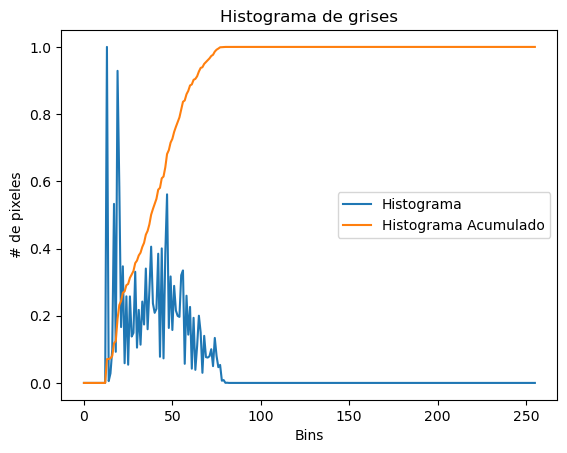

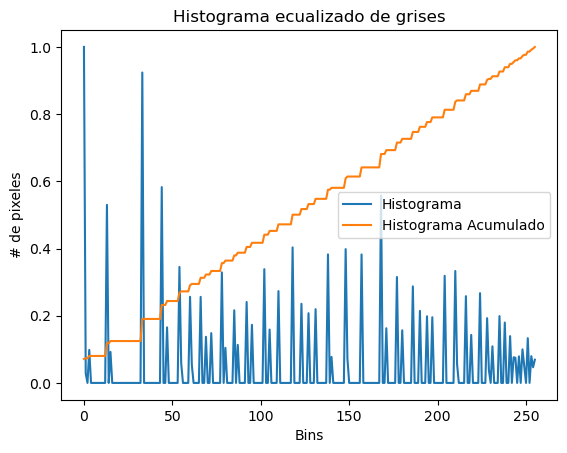

In [31]:
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt

image = cv.imread('recursos/imagen3.png')
gris = cv.cvtColor(image, cv.COLOR_BGR2GRAY)

cv.imshow('Original', image)
cv.imshow('Original en gris', gris)

gris_hist = cv.calcHist([gris], [0] , None,[256], [0,256])
gris_cum = np.cumsum(gris_hist)
plt.figure()
plt.title('Histograma de grises')
plt.xlabel('Bins')
plt.ylabel('# de pixeles')
plt.plot(gris_hist/np.max(gris_hist))
plt.plot(gris_cum/np.max(gris_cum))
plt.legend(['Histograma', 'Histograma Acumulado'],loc='right')
plt.savefig("gray_histogram.svg")
plt.show()

equalized = cv.equalizeHist(gris)
cv.imshow('Ecualizado de grises', equalized)

gris_hist = cv.calcHist([equalized], [0] , None,[256], [0,256])
gris_cum = np.cumsum(gris_hist)
plt.figure()
plt.title('Histograma ecualizado de grises')
plt.xlabel('Bins')
plt.ylabel('# de pixeles')
plt.plot(gris_hist/np.max(gris_hist))
plt.plot(gris_cum/np.max(gris_cum))
plt.legend(['Histograma', 'Histograma Acumulado'],loc='right')
plt.savefig("gray_histogram_equalized.svg")
plt.show()

cv.imwrite('ImagenEqualizada.png', equalized)

cv.waitKey(0)
cv.destroyAllWindows()

5. Elimina el ruido de la imagen resultado del paso 4 utilizando un filtro bilateral con un diámetro d=10 y valores de sigmade 11 y 11. Guarda el resultado comoimagen3_salida.png. (0.5 puntos)

In [32]:
import cv2 as cv
import numpy as np

img = cv.imread('ImagenEqualizada.png')

cv.imshow('Imagen del Paso 4', img)

for i in range(5):
    bilateral = cv.bilateralFilter(img, 10, 11, 11)
    img=bilateral
    cv.imshow('Bilateral', img)
    
cv.imwrite('Imagen3_salida.png', img)

cv.waitKey(0)
cv.destroyAllWindows()

6. Calcula la norma del gradiente de la imagen5.jpgutilizando los operadores de Sobel. Umbraliza los valores de la norma de forma que los valores mayores o iguales a 128 se igualen a 255 y los menores de 128 se igualen a 0. Finalmente, aplica un filtro Gaussiano de radio (7,7) consigma=-1. Guarda el resultado con el nombreimagen5_salida.png. (1.5 puntos)

In [33]:
import cv2 as cv
import numpy as np

def normalizar(image):
    maximo = np.max(image)
    minimo = np.min(image)
    dif = maximo-minimo
    image_norm = 255*(image.astype(np.float32)-minimo)/dif
    return image_norm
    
image = cv.imread('recursos/imagen5.png')
gray = cv.cvtColor(image, cv.COLOR_BGR2GRAY)

dx = cv.Sobel(gray, cv.CV_64F, 1, 0, ksize=3)
dy = cv.Sobel(gray, cv.CV_64F, 0, 1, ksize=3)

gradiante_norma = np.sqrt(dx**2 + dy**2)

gradiante_norma[gradiante_norma>=128] = 255
gradiante_norma[gradiante_norma<128] = 0
gradiante_norma = gradiante_norma.astype(np.uint8)

gauss = cv.GaussianBlur(gradiante_norma, (7, 7), sigmaX=-1)

cv.imshow('Original', image)
cv.imshow('Derivada x',  normalizar(dx).astype(np.uint8))
cv.imshow('Derivada y',  normalizar(dy).astype(np.uint8))
cv.imshow('Gradiante Norma',  gradiante_norma)
cv.imshow('Filtro Gaussiano', gauss)

cv.imwrite('imagen5_salida.png', gauss)

cv.waitKey(0)
cv.destroyAllWindows()


7. Con la imagen4.jpg, crea un vídeo de 100 frames aplicando un filtro mediano de radio (ksize) igual a 7. Aplica el filtro en cada iteración al resultado de la iteración
anterior. Guarda el vídeo con el nombre video4.mp4.(0.5 puntos)

In [34]:
import cv2 as cv
import numpy as np

img = cv.imread('recursos/imagen4.jpg')
alto, ancho, canales = img.shape

frames = 100
fps = 10.0
nombre_video = 'video4.mp4'

fourcc = cv.VideoWriter_fourcc(*'mp4v')
video = cv.VideoWriter(nombre_video, fourcc, fps, (ancho, alto))

frame = img

for i in range(frames):
    video.write(frame)
    frame = cv.medianBlur(frame, 7)

video.release()

print(f"Vídeo guardado como {nombre_video}")

Vídeo guardado como video4.mp4


8. Elimina el ruido de la imagen6.png aplicando todos los
algoritmos vistos en clase para este fin. Si es necesarioaplica los filtros múltiples veces para eliminar el ruido lomejor posible. Haz un breve estudio comparativo entre las
técnicas y selecciona el mejor resultado. (1 punto)

9. Investiga sobre alguna técnica de filtrado distinta a las vistas
en clase. Explícala y codifica un ejemplo de uso. Acontinuación, propón dos filtros de tu invención (lineales ono lineales) especializados en detectar bordes o eliminar
ruido. (1 punto)